In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

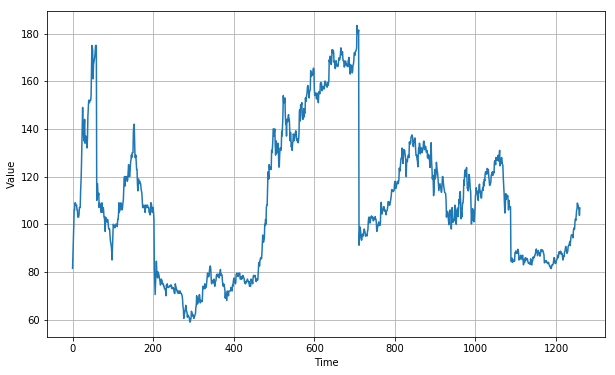

In [3]:
import csv
time_step = []
temps = []

with open('excel_mwg.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000



In [5]:
print(x_train.shape)
print(x_valid.shape)

(1000,)
(260,)


In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




W0801 10:32:18.270860 13044 deprecation.py:323] From C:\Users\sbrn663\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\data\util\random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(1000,)
Epoch 1/100
4/4 [==============================] - 3s 836ms/step - loss: 93.5245 - mae: 94.0075
Epoch 2/100
4/4 [==============================] - 1s 175ms/step - loss: 92.5523 - mae: 93.0622
Epoch 3/100
4/4 [==============================] - 1s 154ms/step - loss: 91.2535 - mae: 91.7633
Epoch 4/100
4/4 [==============================] - 1s 148ms/step - loss: 89.9732 - mae: 90.4895
Epoch 5/100
4/4 [==============================] - 1s 151ms/step - loss: 88.4504 - mae: 88.9742
Epoch 6/100
4/4 [==============================] - 1s 140ms/step - loss: 86.6632 - mae: 87.1945
Epoch 7/100
4/4 [==============================] - 1s 161ms/step - loss: 84.6054 - mae: 85.1445
Epoch 8/100
4/4 [==============================] - 1s 155ms/step - loss: 82.2652 - mae: 82.8124
Epoch 9/100
4/4 [==============================] - 1s 153ms/step - loss: 79.6233 - mae: 80.1793
Epoch 10/100
4/4 [================

4/4 [==============================] - 1s 169ms/step - loss: 27.2581 - mae: 27.7159
Epoch 85/100
4/4 [==============================] - 1s 162ms/step - loss: 27.1332 - mae: 27.5468
Epoch 86/100
4/4 [==============================] - 1s 174ms/step - loss: 26.5494 - mae: 26.9329
Epoch 87/100
4/4 [==============================] - 1s 169ms/step - loss: 26.8162 - mae: 27.1931
Epoch 88/100
4/4 [==============================] - 1s 153ms/step - loss: 26.2644 - mae: 26.6603
Epoch 89/100
4/4 [==============================] - 1s 145ms/step - loss: 26.1434 - mae: 26.5366
Epoch 90/100
4/4 [==============================] - 1s 152ms/step - loss: 26.3327 - mae: 26.7185
Epoch 91/100
4/4 [==============================] - 1s 161ms/step - loss: 26.1695 - mae: 26.5633
Epoch 92/100
4/4 [==============================] - 1s 159ms/step - loss: 25.9073 - mae: 26.3056
Epoch 93/100
4/4 [==============================] - 1s 157ms/step - loss: 27.0844 - mae: 26.8950
Epoch 94/100
4/4 [=========================

[1e-08, 0.0001, 0, 60]

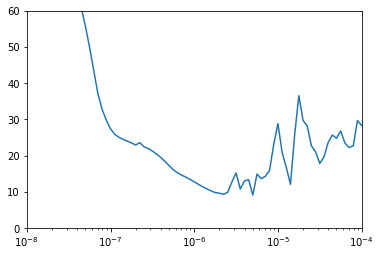

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [10]:
print(train_set)
print(x_valid.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(260,)


In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=300)

Epoch 1/300
10/10 [==============================] - 3s 341ms/step - loss: 66.6245 - mae: 69.3441
Epoch 2/300
10/10 [==============================] - 1s 72ms/step - loss: 30.1654 - mae: 30.5386
Epoch 3/300
10/10 [==============================] - 1s 72ms/step - loss: 27.9094 - mae: 28.4592
Epoch 4/300
10/10 [==============================] - 1s 69ms/step - loss: 23.9269 - mae: 24.4655
Epoch 5/300
10/10 [==============================] - 1s 69ms/step - loss: 20.2576 - mae: 20.7502
Epoch 6/300
10/10 [==============================] - 1s 90ms/step - loss: 18.1665 - mae: 18.6544
Epoch 7/300
10/10 [==============================] - 1s 86ms/step - loss: 16.4073 - mae: 16.8991
Epoch 8/300
10/10 [==============================] - 1s 85ms/step - loss: 15.2954 - mae: 15.7807
Epoch 9/300
10/10 [==============================] - 1s 76ms/step - loss: 14.4694 - mae: 14.9622
Epoch 10/300
10/10 [==============================] - 1s 69ms/step - loss: 13.6591 - mae: 14.1588
Epoch 11/300
10/10 [========

10/10 [==============================] - 1s 70ms/step - loss: 3.9219 - mae: 4.4123
Epoch 87/300
10/10 [==============================] - 1s 63ms/step - loss: 3.9086 - mae: 4.3987
Epoch 88/300
10/10 [==============================] - 1s 67ms/step - loss: 3.8917 - mae: 4.3815
Epoch 89/300
10/10 [==============================] - 1s 66ms/step - loss: 3.8851 - mae: 4.3752
Epoch 90/300
10/10 [==============================] - 1s 64ms/step - loss: 3.8787 - mae: 4.3691
Epoch 91/300
10/10 [==============================] - 1s 67ms/step - loss: 3.8712 - mae: 4.3620
Epoch 92/300
10/10 [==============================] - 1s 77ms/step - loss: 3.8635 - mae: 4.3545
Epoch 93/300
10/10 [==============================] - 1s 71ms/step - loss: 3.8509 - mae: 4.3417
Epoch 94/300
10/10 [==============================] - 1s 70ms/step - loss: 3.8421 - mae: 4.3330
Epoch 95/300
10/10 [==============================] - 1s 72ms/step - loss: 3.8347 - mae: 4.3258
Epoch 96/300
10/10 [==============================] -

10/10 [==============================] - 1s 67ms/step - loss: 2.6059 - mae: 3.0547
Epoch 171/300
10/10 [==============================] - 1s 66ms/step - loss: 2.8285 - mae: 3.2689
Epoch 172/300
10/10 [==============================] - 1s 69ms/step - loss: 2.9470 - mae: 3.4314
Epoch 173/300
10/10 [==============================] - 1s 66ms/step - loss: 2.7521 - mae: 3.1802
Epoch 174/300
10/10 [==============================] - 1s 71ms/step - loss: 2.8223 - mae: 3.2772
Epoch 175/300
10/10 [==============================] - 1s 69ms/step - loss: 2.8540 - mae: 3.3218
Epoch 176/300
10/10 [==============================] - 1s 69ms/step - loss: 2.7400 - mae: 3.2059
Epoch 177/300
10/10 [==============================] - 1s 72ms/step - loss: 2.7107 - mae: 3.1551
Epoch 178/300
10/10 [==============================] - 1s 68ms/step - loss: 2.8013 - mae: 3.2561
Epoch 179/300
10/10 [==============================] - 1s 66ms/step - loss: 2.8125 - mae: 3.2786
Epoch 180/300
10/10 [=======================

10/10 [==============================] - 1s 67ms/step - loss: 2.4479 - mae: 2.9073
Epoch 255/300
10/10 [==============================] - 1s 62ms/step - loss: 2.4461 - mae: 2.9056
Epoch 256/300
10/10 [==============================] - 1s 64ms/step - loss: 2.4421 - mae: 2.9017
Epoch 257/300
10/10 [==============================] - 1s 66ms/step - loss: 2.4398 - mae: 2.8991
Epoch 258/300
10/10 [==============================] - 1s 67ms/step - loss: 2.4375 - mae: 2.8970
Epoch 259/300
10/10 [==============================] - 1s 65ms/step - loss: 2.4334 - mae: 2.8929
Epoch 260/300
10/10 [==============================] - 1s 64ms/step - loss: 2.4305 - mae: 2.8899
Epoch 261/300
10/10 [==============================] - 1s 69ms/step - loss: 2.4274 - mae: 2.8868
Epoch 262/300
10/10 [==============================] - 1s 72ms/step - loss: 2.4253 - mae: 2.8846
Epoch 263/300
10/10 [==============================] - 1s 71ms/step - loss: 2.4241 - mae: 2.8834
Epoch 264/300
10/10 [=======================

In [12]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

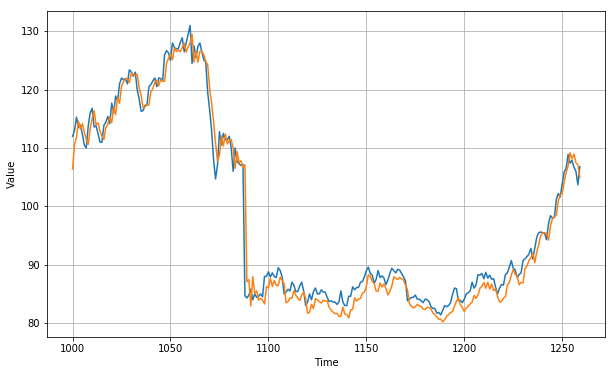

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [14]:
print(rnn_forecast.shape)

(260,)


In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.8137504

<Figure size 432x288 with 0 Axes>

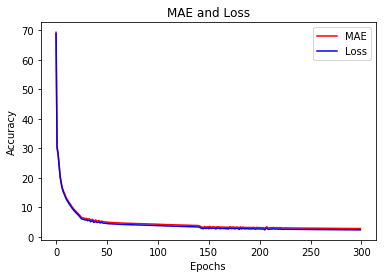

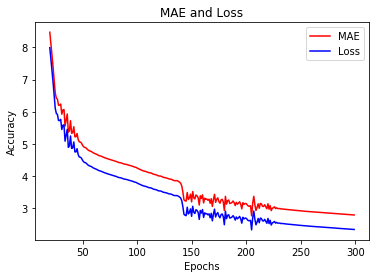

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[20:]
mae_zoom = mae[20:]
loss_zoom = loss[20:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [17]:
#model.predict(series[1260:1290][np.newaxis])